In [ ]:
#default_exp pipeline

# Pipeline

<br>

### Imports

In [ ]:
#exports
import numpy as np
import pandas as pd

import os

from dagster import execute_pipeline, pipeline, solid, Field
from batopt import clean, discharge, charge, constraints

In [ ]:
import FEAutils as hlp
import matplotlib.pyplot as plt

<br>

### End-to-End

We're now going to combine these steps into a pipeline using dagster, first we'll create the individual components.

In [ ]:
@solid()
def load_data(_, raw_data_dir: str):
    loaded_data = dict()
    
    loaded_data['pv'] = clean.load_training_dataset(raw_data_dir, 'pv')
    loaded_data['demand'] = clean.load_training_dataset(raw_data_dir, 'demand')
    loaded_data['weather'] = clean.load_training_dataset(raw_data_dir, 'weather', dt_idx_freq='H')
    
    return loaded_data

@solid()
def clean_data(_, loaded_data, intermediate_data_dir: str):
    # Cleaning
    cleaned_data = dict()

    cleaned_data['pv'] = (loaded_data['pv']
                          .pipe(clean.pv_anomalies_to_nan)
                          .pipe(clean.interpolate_missing_panel_temps, loaded_data['weather'])
                          .pipe(clean.interpolate_missing_site_irradiance, loaded_data['weather'])
                          .pipe(clean.interpolate_missing_site_power)
                         )
    cleaned_data['weather'] = clean.interpolate_missing_weather_solar(loaded_data['pv'], loaded_data['weather'])
    cleaned_data['demand'] = loaded_data['demand']
    
    # Saving
    if os.path.exists(intermediate_data_dir) == False:
        os.mkdir(intermediate_data_dir)
        
    cleaned_data['pv'].to_csv(f'{intermediate_data_dir}/pv_cleaned.csv')
    cleaned_data['demand'].to_csv(f'{intermediate_data_dir}/demand_cleaned.csv')
    cleaned_data['weather'].to_csv(f'{intermediate_data_dir}/weather_cleaned.csv')
            
    return intermediate_data_dir

@solid()
def fit_and_save_charge_model(_, intermediate_data_dir: str, charge_opt_model_fp: str, model_params: dict):
    X, y = charge.prepare_training_input_data(intermediate_data_dir)
    charge.fit_and_save_charging_model(X, y, charge_opt_model_fp, **model_params)
    
    return True

@solid()
def fit_and_save_discharge_model(_, intermediate_data_dir: str, discharge_opt_model_fp: str, model_params: dict):
    X, y = discharge.prepare_training_input_data(intermediate_data_dir)
    discharge.fit_and_save_model(X, y, discharge_opt_model_fp, **model_params)
    
    return True

@solid()
def construct_battery_profile(_, charge_model_success: bool, discharge_model_success: bool, intermediate_data_dir: str, raw_data_dir: str, discharge_opt_model_fp: str, charge_opt_model_fp: str):
    assert charge_model_success and discharge_model_success, 'Model training was unsuccessful'
    
    s_discharge_profile = discharge.optimise_latest_test_discharge_profile(raw_data_dir, intermediate_data_dir, discharge_opt_model_fp)
    s_charge_profile = charge.optimise_latest_test_charge_profile(raw_data_dir, intermediate_data_dir, charge_opt_model_fp)
    
    s_battery_profile = s_charge_profile + s_discharge_profile
    s_battery_profile.name = 'charge_MW'
    
    return s_battery_profile

@solid()
def check_and_save_battery_profile(_, s_battery_profile, output_data_dir: str):
    # Check that solution meets battery constraints
    assert constraints.schedule_is_legal(s_battery_profile), "Solution violates constraints"
    
    # Saving
    if os.path.exists(output_data_dir) == False:
        os.mkdir(output_data_dir)
        
    s_battery_profile.to_csv(f'{output_data_dir}/latest_submission.csv')
    
    return 

<br>

Then we'll combine them in a pipeline

In [ ]:
@pipeline
def end_to_end_pipeline(): 
    loaded_data = load_data()
    intermediate_data_dir = clean_data(loaded_data)
    
    charge_model_success = fit_and_save_charge_model(intermediate_data_dir)
    discharge_model_success = fit_and_save_discharge_model(intermediate_data_dir)
    
    s_battery_profile = construct_battery_profile(charge_model_success, discharge_model_success, intermediate_data_dir)
    check_and_save_battery_profile(s_battery_profile)

<br>

Which we'll now run a test

In [ ]:
run_config = {
    'solids': {
        'load_data': {
            'inputs': {
                'raw_data_dir': '../data/raw',
            },
        },
        'clean_data': {
            'inputs': {
                'intermediate_data_dir': '../data/intermediate',
            },
        },
        'fit_and_save_discharge_model': {
            'inputs': {
                'discharge_opt_model_fp': '../models/discharge_opt.sav',
                'model_params': {
                    'criterion': 'mse',
                    'max_depth': 10,
                    'min_samples_leaf': 4,
                    'min_samples_split': 2,
                    'n_estimators': 100                    
                }
            },
        },
        'fit_and_save_charge_model': {
            'inputs': {
                'charge_opt_model_fp': '../models/charge_opt.sav',
                'model_params': {               
                }
            },
        },
        'construct_battery_profile': {
            'inputs': {
                'raw_data_dir': '../data/raw',
                'discharge_opt_model_fp': '../models/discharge_opt.sav',
                'charge_opt_model_fp': '../models/charge_opt.sav',
            },
        },
        'check_and_save_battery_profile': {
            'inputs': {
                'output_data_dir': '../data/output'
            },
        },
    }
}

execute_pipeline(end_to_end_pipeline, run_config=run_config)

2021-02-10 15:47:47 - dagster - DEBUG - end_to_end_pipeline - 5e9b1b45-01ea-43c9-be49-9f238d71da0b - 5768 - ENGINE_EVENT - Starting initialization of resources [asset_store].
2021-02-10 15:47:47 - dagster - DEBUG - end_to_end_pipeline - 5e9b1b45-01ea-43c9-be49-9f238d71da0b - 5768 - ENGINE_EVENT - Finished initialization of resources [asset_store].
2021-02-10 15:47:47 - dagster - DEBUG - end_to_end_pipeline - 5e9b1b45-01ea-43c9-be49-9f238d71da0b - 5768 - PIPELINE_START - Started execution of pipeline "end_to_end_pipeline".
2021-02-10 15:47:47 - dagster - DEBUG - end_to_end_pipeline - 5e9b1b45-01ea-43c9-be49-9f238d71da0b - 5768 - ENGINE_EVENT - Executing steps in process (pid: 5768)
2021-02-10 15:47:47 - dagster - DEBUG - end_to_end_pipeline - 5e9b1b45-01ea-43c9-be49-9f238d71da0b - 5768 - load_data.compute - STEP_START - Started execution of step "load_data.compute".
2021-02-10 15:47:47 - dagster - DEBUG - end_to_end_pipeline - 5e9b1b45-01ea-43c9-be49-9f238d71da0b - 5768 - load_data.comp

<br>

We'll then visualise the latest charging profile

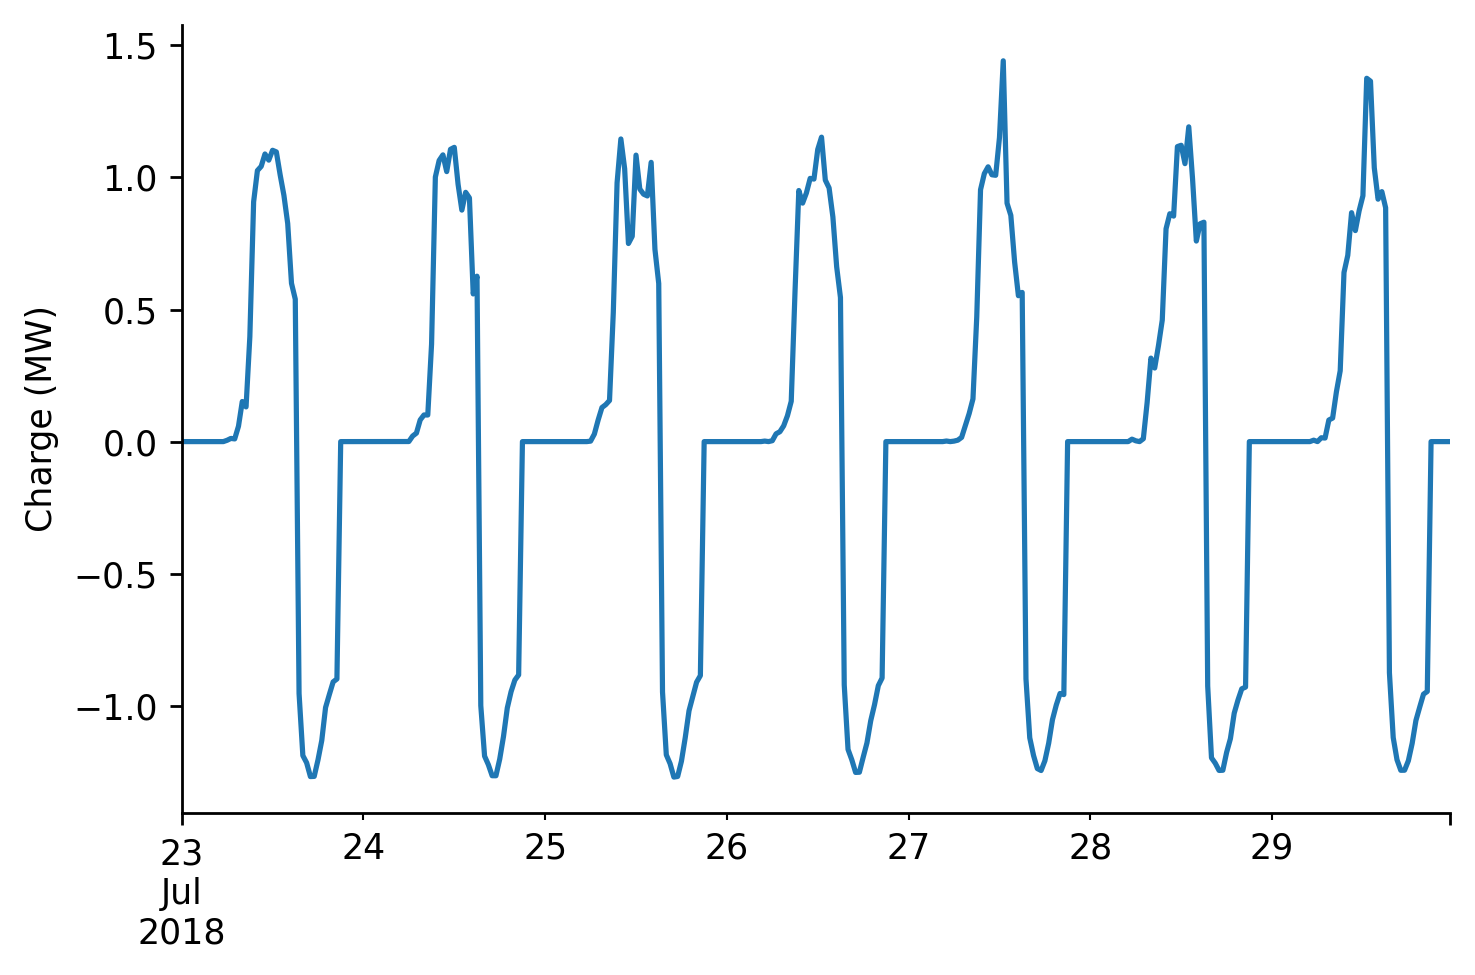

In [ ]:
df_latest_submission = pd.read_csv('../data/output/latest_submission.csv')

s_latest_submission = df_latest_submission.set_index('datetime')['charge_MW']
s_latest_submission.index = pd.to_datetime(s_latest_submission.index)

# Plotting
fig, ax = plt.subplots(dpi=250)

s_latest_submission.plot(ax=ax)

ax.set_xlabel('')
ax.set_ylabel('Charge (MW)')
hlp.hide_spines(ax)
fig.tight_layout()
fig.savefig('../img/latest_submission.png', dpi=250)

<br>

Finally we'll export the relevant code to our `batopt` module

In [ ]:
#hide
from nbdev.export import notebook2script
    
notebook2script()

Converted 00-utilities.ipynb.
Converted 01-cleaning.ipynb.
Converted 02-discharging.ipynb.
Converted 03-charging.ipynb.
Converted 04-constraints.ipynb.
Converted 05-pipeline.ipynb.
